# fruits-300 inuk 🍎
---

In [394]:
cd /content/drive/MyDrive/Colab Notebooks/python-mldlnl/deep-learning/D-0919

/content/drive/MyDrive/Colab Notebooks/python-mldlnl/deep-learning/D-0919


In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import SilhouetteVisualizer

plt.style.use('seaborn-white')
np.random.seed(42)

## [1] 데이터 불러오기
---

In [396]:
fruits = np.load("./fruits_300.npy")

In [397]:
fruits.shape

(300, 100, 100)

## [2] 데이터 전처리 클래스

In [398]:
class kmean_data():
    """KMean
    kmean class
    """
    def __init__(self, data, n_component=0.95):
        self.data = data
        self.n_component = n_component


    def preprocessing(self, inverse=False, model=False):
        """preprocessing method
        scaling, flat, pca
        """
        data_scaled = (self.data)/255.
        data_flat = data_scaled.reshape(-1, data_scaled.shape[1] * data_scaled.shape[2])
        pca = PCA(n_components=self.n_component).fit(data_flat)
        data_pca = pca.transform(data_flat)

        if inverse == True:
            data_inverse = pca.inverse_transform(data_pca)
            return data_inverse
        elif model == True:
            return pca
    
        return data_pca
    
    
    def return_inverse(self, reshape=False):
        """returm inverse data
        """
        data = self.preprocessing(inverse=True)

        if reshape == True:
            return data.reshape(-1, self.data.shape[1], self.data.shape[2])

        return data


    def draw_plot(self, max_cluster):
        """draw cluster inertia plot
        """
        x = []
        y = []

        data = self.preprocessing()

        for i in range(1, max_cluster+1):
            cluster = KMeans(i).fit(data)
            num = cluster.inertia_
            x.append(i)
            y.append(num)

        plt.plot(x, y, color="royalblue")
        plt.xticks(x)
        plt.xlabel("cluster")
        plt.ylabel("inertia")
        plt.show()


    def return_labels(self, cluster):
        """return labels
        """
        data = self.preprocessing()

        data_km = KMeans(n_clusters=cluster).fit(data)
        labels = data_km.labels_

        return labels

    def draw_silhouette_plot(self, max_cluster):
        """draw silhouette plot
        """
        x = []
        y = []

        data = self.preprocessing()

        for i in range(2, max_cluster+1):
            labels = self.return_labels(i)
            score = silhouette_score(data, labels)

            x.append(i)
            y.append(score)

        plt.plot(x, y, color="red")
        plt.xticks(x)
        plt.xlabel("cluster")
        plt.ylabel("silhouette score")
        plt.show()

    
    def draw_silhouette_score(self, start_cluster=2):
        """draw silhouette_score
        """
        data = self.preprocessing() 

        fig, ax = plt.subplots(3, 2, figsize=(15,8))
        for i in range(start_cluster, start_cluster+6):

            q_num = list(range(start_cluster, start_cluster+6)).index(i)
 
            km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
            q, mod = divmod(2+q_num, 2)

            visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
            visualizer.fit(data)  

## [3] KMean 이용해서 라벨 만들기

In [399]:
# 객체 생성
fruits_data = kmean_data(fruits, 0.95)

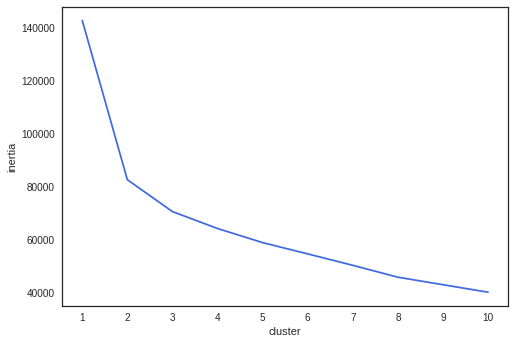

In [400]:
# plot 그려서 cluster값 확인
fruits_data.draw_plot(10)

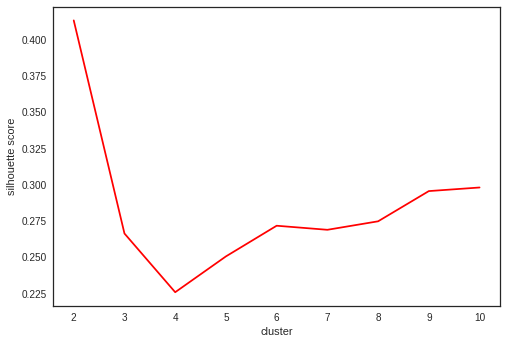

In [401]:
fruits_data.draw_silhouette_plot(10)

https://vitalflux.com/elbow-method-silhouette-score-which-better/

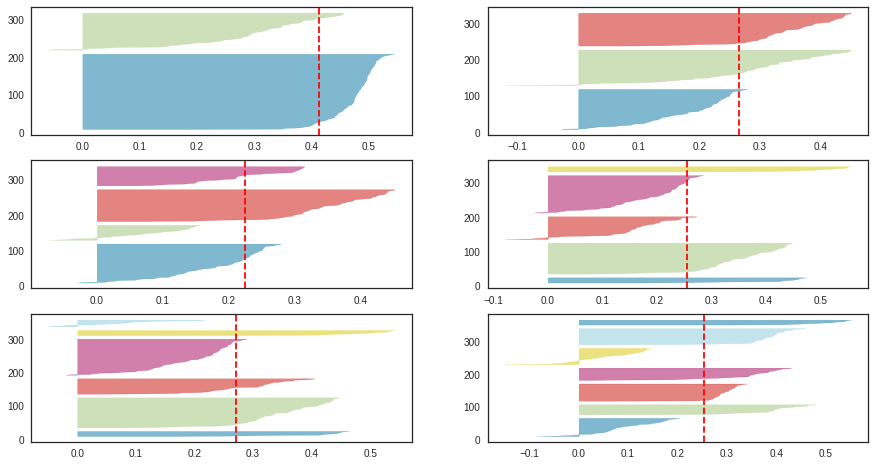

In [402]:
fruits_data.draw_silhouette_score(2)

In [403]:
# 라벨 생성
label = fruits_data.return_labels(3)

## [4] 모델 생성

### [4-1] 지도학습용 데이터 전처리

In [404]:
X = kmean_data(fruits).preprocessing()
y = kmean_data(fruits).return_labels(3)

In [405]:
X_1, X_test, y_1, y_test = train_test_split(
    X, y, stratify=label, random_state=42, test_size=0.2
)

In [406]:
X_train, X_val, y_train, y_val = train_test_split(
    X_1, y_1, stratify=y_1, random_state=42, test_size=0.2
)

## [5] 모델 학습, 평가

In [407]:
model = xgb.XGBClassifier()

param_grid={
    'max_depth': [5, 6, 8],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree':[0.5, 0.8],
    "reg_alpha": [0.01, 0.1, 1, 10, 100]
}

gcv=GridSearchCV(model, param_grid=param_grid, cv=5)

gcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.8], 'max_depth': [5, 6, 8],
                         'min_child_weight': [1, 3, 5],
                         'reg_alpha': [0.01, 0.1, 1, 10, 100]})

In [408]:
print('final params', gcv.best_params_)
print('best score', gcv.best_score_)

final params {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0.01}
best score 0.9897435897435898


In [409]:
model = xgb.XGBClassifier(
    colsample_bytree=0.5,
    max_depth=5,
    min_child_weight=3,
    reg_alpha=0.01
)

In [410]:
model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5, max_depth=5, min_child_weight=3,
              objective='multi:softprob', reg_alpha=0.01)

In [411]:
print(f"train score : {model.score(X_train, y_train)}")
print(f"test score : {model.score(X_test, y_test)}")

train score : 1.0
test score : 0.9833333333333333


## [6] 다른 데이터 예측

In [418]:
# pca 정보 가져오기
pca = fruits_data.preprocessing(model=True)
len = len(pca.explained_variance_ratio_)